# **Phys 427 Final Project: Gravitational Waves**

## *Jeff Capoeman*
## 25 February 2020

In [354]:
import numpy as np
import matplotlib.pyplot as plot
import scipy as sc
import h5py

## **Importing Data**

In [355]:
# First downloaded hdf5 file from GW open science center and renamed the file
# Data taken is from GW151226
WaveData = h5py.File('H1_4kHz.hdf5', 'r')

# Exploring type of data in file
list(WaveData.keys())

['meta', 'quality', 'strain']

### hdf5 files are categorized in groups, and these groups can have more grouped objects within them. You can keep using the keys function to explore data files and see what is inside them. Strain data holds the actual measurements and opening the group you see that it only has one group within it that has the actuald data set named 'Strain'. Meta group has data sets within it such as the local gps time. 

In [356]:
meta = WaveData['meta']
quality = WaveData['quality']
strain = WaveData['strain']

In [357]:
print(strain.keys())
print(meta.keys())
print(quality.keys())

<KeysViewHDF5 ['Strain']>
<KeysViewHDF5 ['Description', 'DescriptionURL', 'Detector', 'Duration', 'GPSstart', 'Observatory', 'Type', 'UTCstart']>
<KeysViewHDF5 ['detail', 'injections', 'simple']>


In [358]:
Y_ax = strain['Strain'] # y axis data

ts = strain['Strain'].attrs['Xspacing'] # extracts time lapse between each data point
Duration = meta[('Duration')].value # scalar duration of the time of measurement
GPSstarttime = meta[('GPSstart')].value #scalar starting gps time
GPSendtime = GPSstarttime + Duration

C:\Users\jcapo\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [359]:
Y_ax.shape #this shows the size of the data set so we can create an array

(131072,)

In [360]:
Y_ax = Y_ax[0:131072] # creates a numpy array of the specified size above

t = np.arange(GPSstarttime, GPSendtime, ts) # creates numpy array of time data, x axis

### From the above code, we now have the full working data set that we can plot. The plot of this data is noisy with many frequencies so moving ahead we will now need to filter the data to extract what we want.

## **Plotting Data**

Text(0, 0.5, 'Strain')

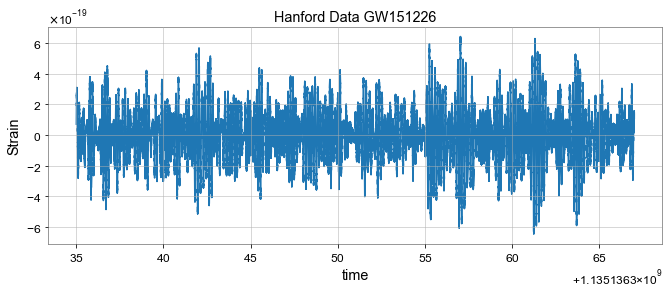

In [361]:
plot.figure(figsize = (11,4))
plot.plot(t, Y_ax)
plot.title('Hanford Data GW151226')
plot.xlabel('time')
plot.ylabel('Strain')

### This plot, however is too bunched so you need to zoom in around the time of detection. We must tweak our data slightly so that we can zoom in on the sight of detection

In [362]:
tevent = 1135136350 # GPS time of the detected event found on the GW open science center website
deltat = 5 # we will take an interval of 5 data points before and after the detection time
indxt = np.where((t >= tevent-deltat) & (t < tevent+deltat)) 

tzoom = t[indxt] - tevent
Yzoom = Y_ax[indxt]

Text(0, 0.5, 'Strain')

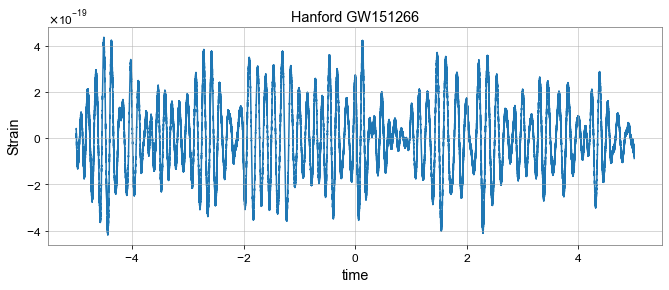

In [363]:
plot.figure(figsize = (11, 4))
plot.plot(tzoom, Yzoom)
plot.title('Hanford GW151266')
plot.xlabel('time')
plot.ylabel('Strain')

# **Filtering Data**

#### The data we have is very noisy so we will have to go through a few rounds of filtering. I will use the steps outlined in the paper "A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals" written by the LIGO group. The steps outlined are, widnow with a Tukey Window, Fast Fourier Transform(FFT), whiten data by dividing FFT with an estimate of the Amplitude Spectral Density(ASD), then returning to the data format by using an Inverse Fourier Transform(iFFT). The last step to amplify the detection is a butterworth filter.



## Tukey Window

In [290]:
A = len(Yzoom)

tukey = sc.signal.tukey(A) #made tukey window function same length as zoomed data
tukey = tukey*Yzoom # applied tukey window

Text(0, 0.5, 'Strain')

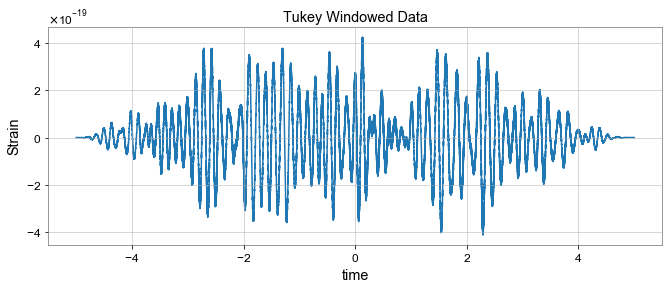

In [365]:
plot.figure(figsize = (11,4))
plot.plot(tzoom, tukey)
plot.title('Tukey Windowed Data')
plot.xlabel('time')
plot.ylabel('Strain')

## Data Whitening

#### Data whitening in this filtering method was applied by dividing the coefficients of the fast fourier transform by the power spectral density

In [366]:
A = len(tukey)

Pxx, freqs = plot.mlab.psd(tukey, Fs = 4000, NFFT = 16000) #Fs is sampling rate, NFFT is 4*Fs
PSD = np.sqrt(Pxx)
# Pxx gives power spectral density
# PSD is the Amplitude Spectral Density

### Made sure the PSD plot matched GWOSC

Text(0, 0.5, 'sqrt Pxx')

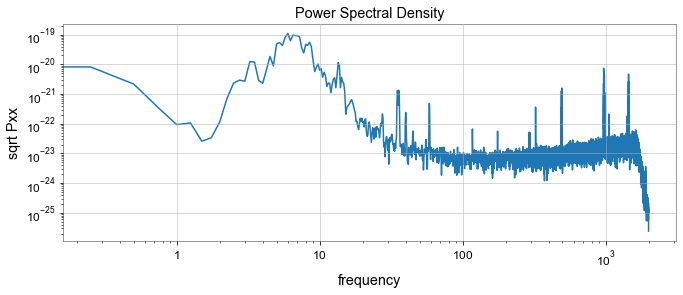

In [367]:
plot.figure(figsize = (11,4))
plot.loglog(freqs, PSD)
plot.title('Power Spectral Density')
plot.xlabel('frequency')
plot.ylabel('sqrt Pxx')

In [368]:
f = np.fft.rfftfreq(A, ts)
P_interp = np.interp(f, freqs, Pxx) # interpolated power spectral density using fourier frequencies as xnew
PSD = np.sqrt(P_interp) # sqrt of Power density gives amplitude density

fft = np.fft.rfft(tukey) #creates numpy array for fft
norm = norm = 1./np.sqrt(1./(ts*2)) # suggested normalization factor

Whitened = fft/PSD * norm # This is the actual data whitening step
Whitened = sc.ifft(Whitened, n = A) #this is our final whitened data with the inverse fft to plot

C:\Users\jcapo\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Strain')

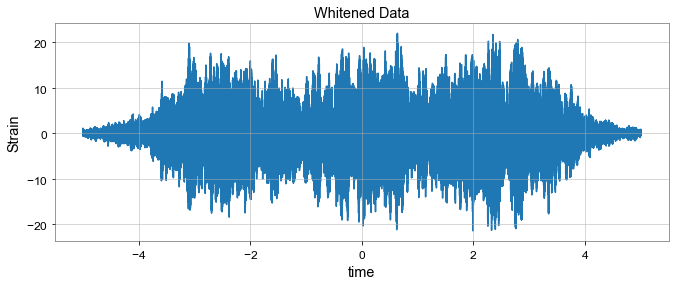

In [369]:
plot.figure(figsize = (11, 4))
plot.plot(tzoom, Whitened)
plot.title('Whitened Data')
plot.xlabel('time')
plot.ylabel('Strain')

## Butterworth Filter

In [370]:
b, a = sc.signal.butter(4, [35/2000, 250/2000], btype = 'band') #scipy function for butterworth filter
Butterworth = sc.signal.filtfilt(b, a, Whitened) #applies filter to data

Text(0, 0.5, 'Strain')

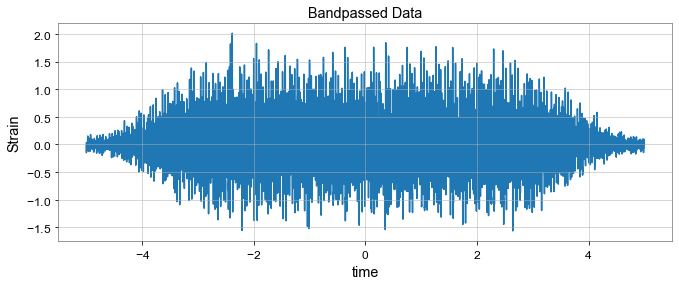

In [371]:
plot.figure(figsize = (11, 4))
plot.plot(tzoom, Butterworth)
plot.title('Bandpassed Data')
plot.xlabel('time')
plot.ylabel('Strain')

## Inconclusive filtering. Use GWpy.

#### The results of creating a filtering method using simple numpy and scipy packages was inconclusive. Possible reasons could be the different usage of scipy and numpy packages in my code above and the code that LIGO used. In the open access tutorials, LIGO used scipy.interp1d where as I used np.interp. The difference here is that the scipy method returns a function where you later have to call it to make an array, and the numpy version creates an array when you first use the interpolation. I am unaware of how this would effect the filtering methods however.

#### You can also see that I'm losing data on the ends. This is indicative of a tukey window which tapers at the ends. I imagine there is a way to get around this by overlapping the data somewhere, but I could not figure this out.

#### While deep internet searching for answers, I found that LIGO has created it's own analysis package, GWpy, to analyze it's own data. The package has prewrapped functions that handle all of the signal processing. The original goal of this project was to analyze these signal processing functions, but it seems that the programmers at LIGO are using a key piece of information that I am missing. 

#### I take no credit for the following written code, it was modeled after the pre-written functions already built by LIGO.

In [340]:
from gwpy.timeseries import TimeSeries

h1 = TimeSeries.fetch_open_data('H1', GPSstarttime, GPSendtime) #re-downloads same event data above

In [344]:
h1b = h1.bandpass(50, 250).notch(60).notch(120) #whitened data with filter limits at 50 and 250 Hz
# notched filters at 60 and 120 Hz

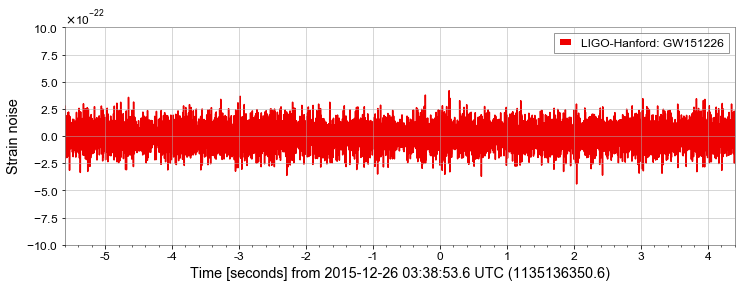

In [345]:
from gwpy.plot import Plot
plot = Plot(figsize=(12, 4))
ax = plot.gca(xscale='auto-gps')
ax.plot(h1b, color='gwpy:ligo-hanford', label='LIGO-Hanford: GW151226')
ax.set_epoch(1135136350.6) # centers the data with event time on zero
ax.set_xlim(1135136345, 1135136355)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

### One may be able to make a case for a possible detection event near time 0, however using this plot alone to see an event would be erroneous. 

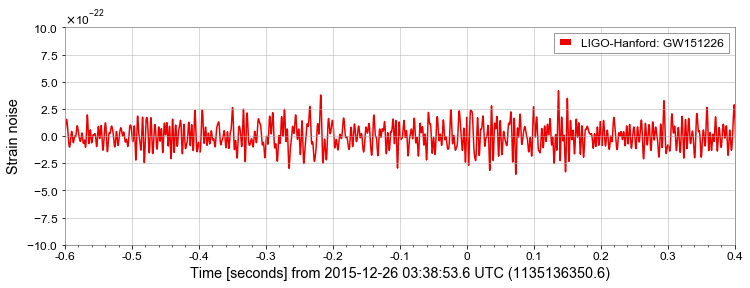

In [346]:
# let's zoom in on the event time
from gwpy.plot import Plot
plot = Plot(figsize=(12, 4))
ax = plot.gca(xscale='auto-gps')
ax.plot(h1b, color='gwpy:ligo-hanford', label='LIGO-Hanford: GW151226')
ax.set_epoch(1135136350.6)
ax.set_xlim(1135136350, 1135136351)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()


### Signal is still very noisy, and I am still quite uncertain of seeing an event at the supposed event time. However, one can make a case that there is an underlying oscillation with a period of 0.3 s and after the event time detection, there is no underlying oscillation.

In [364]:
from gwpy.timeseries import TimeSeries
h1 = TimeSeries.fetch_open_data('H1', 1167559931.6, 1167559941.6) #downloads next event data above

h1b = h1.bandpass(50, 250).notch(60).notch(120) #bandpass filter with 

#notch filter applied in regions of strong spectral density of known noise(e.g. power lines in America
#have a signature sampling frequency of 60 Hz).

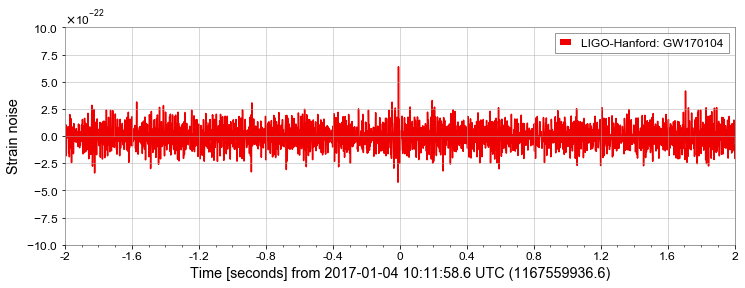

In [352]:
from gwpy.plot import Plot
plot = Plot(figsize=(12, 4))
ax = plot.gca(xscale='auto-gps')
ax.plot(h1b, color='gwpy:ligo-hanford', label='LIGO-Hanford: GW170104')
ax.set_epoch(1167559936.6)
ax.set_xlim(1167559934.6, 1167559938.6)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

### This data yields a much better plot and an event is obvious near time zero. These results were all using the same method of filtering 'static noise' of the data. 

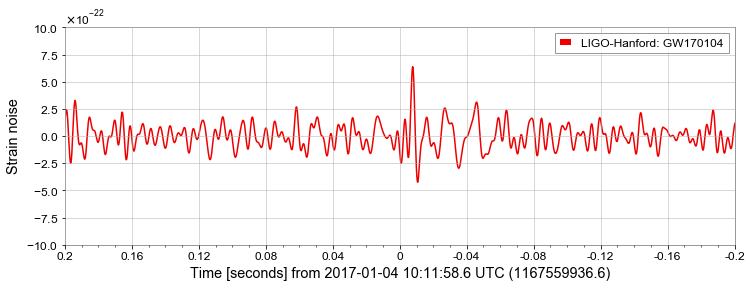

In [353]:
# again zooming in
from gwpy.plot import Plot
plot = Plot(figsize=(12, 4))
ax = plot.gca(xscale='auto-gps')
ax.plot(h1b, color='gwpy:ligo-hanford', label='LIGO-Hanford: GW170104')
ax.set_epoch(1167559936.6)
ax.set_xlim(1167559936.8, 1167559936.4)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

## Conclusion


#### I am in no position to question LIGOS analysis of their own data; however, I am unable to find an event detection with strong confidence for GW151226 centered aroudn GPS time 1135136350.6. GW170104 does give a strong apparent visual case for an event. 

#### Commenting again on the analysis of LIGO's filtering methods that I tried to derive, GW151226 was not an optimal event to attempt to derive a noise filtering function using simple numpy and scipy packages. Even if results did yield something correct, detection would not be easy given the strength of the 'signal'. 